In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pandas as pd
# import seaborn as sns
# from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import math
from sklearn.metrics import accuracy_score
rng = np.random.default_rng(51)
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import numpy as np
from pandas import read_csv

In [2]:

attrib = read_csv('attributes.csv', delim_whitespace = True)
data = read_csv('communities.data', names = attrib['attributes'])

In [3]:
data.shape

(1994, 128)

In [4]:
data.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


Remove non-predictive features

state: US state (by number) - not counted as predictive above, but if considered, should be considered nominal (nominal)
county: numeric code for county - not predictive, and many missing values (numeric)
community: numeric code for community - not predictive and many missing values (numeric)
communityname: community name - not predictive - for information only (string)
fold: fold number for non-random 10 fold cross validation, potentially useful for debugging, paired tests - not predictive (numeric)

In [5]:
from pandas import DataFrame

data = data.replace('?', np.nan)
feat_miss = data.columns[data.isnull().any()]

In [6]:
print(feat_miss)
feat_miss.shape

Index(['county', 'community', 'OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop',
       'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq',
       'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop',
       'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp',
       'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits',
       'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg',
       'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop'],
      dtype='object')


(25,)

In [7]:
data[feat_miss[0:25]].describe()

,county,community,OtherPerCap,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,...,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,PolicBudgPerPop
count,820,817,1993,319,319,319,319,319,319,319,...,319,319,319,319,319,319,319,319,319,319
unique,108,799,97,38,52,34,55,44,59,75,...,50,72,30,15,77,63,38,72,3,51
top,3,11000,0,0.02,0.1,0.98,0.19,0.02,0.14,0.23,...,0,0.07,0.03,0.57,0.19,0.02,0.02,0.74,0,0.12
freq,72,2,129,80,19,81,17,55,23,15,...,189,14,48,54,12,27,69,13,126,22


In [8]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer = imputer.fit(data[['OtherPerCap']])
data[['OtherPerCap']] = imputer.transform(data[['OtherPerCap']])

In [9]:
data = data.dropna(axis=1)
print(data.shape)
data.head()

(1994, 104)


,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,8,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,53,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,24,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,34,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [10]:
data = data.drop(columns=['communityname'])

In [11]:
X = data.iloc[:, 0:102]
y = data.iloc[:, 102]

from sklearn.model_selection import train_test_split

seed = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed)

In [12]:

reg = LinearRegression().fit(X_train, y_train)
pred = reg.predict(X_test)

In [13]:
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 0.019132148643797458
R^2 Score: 0.6434211880823766


/Users/admin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/admin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/admin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


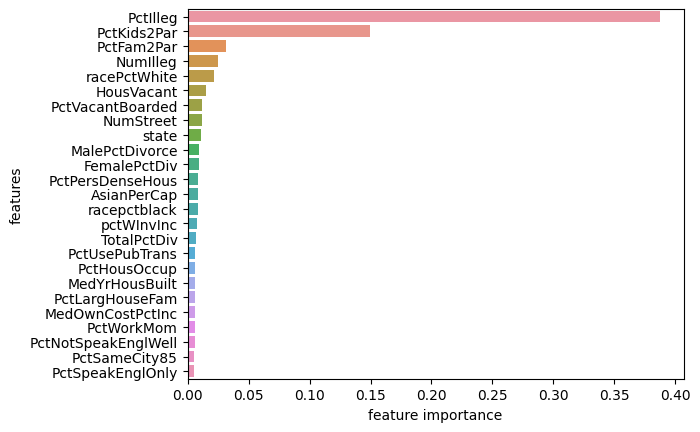

In [14]:

from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=100, random_state=0)
regr.fit(X_train, y_train)
feat_importances = pd.Series(regr.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feat_importances[:25], y=feat_importances.index[:25])
plt.xlabel('feature importance')
plt.ylabel('features')
plt.show()

#feat_importances.plot(kind='barh')

9 фич

In [25]:
f = feat_importances[:10].index

X_train_rf = X_train.filter(items=f)
X_test_rf = X_test.filter(items=f)

reg = LinearRegression().fit(X_train_rf, y_train)
pred = reg.predict(X_test_rf)



In [26]:
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 0.019937473132267253
R^2 Score: 0.6284118101681075


In [24]:
f = feat_importances[:5].index

X_train_rf = X_train.filter(items=f)
X_test_rf = X_test.filter(items=f)

reg = LinearRegression().fit(X_train_rf, y_train)
pred = reg.predict(X_test_rf)

mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 0.020705312435518163
R^2 Score: 0.6141010690383794
